In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fftpack
from scipy.signal import find_peaks

import ipytest
ipytest.autoconfig()
from pytest import approx

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Probe.Plot import plot
from PySpice.Math import *

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

# construction

There are various wavefolder circuits out there. the most famous is the serge wave multiplier middle section. Welle is implemented using the basic idea from Jürgen Haible [[1](http://jhaible.com/legacy/jh_wavefolder.html)] and the modifications from Yves Usson [[2](https://www.yusynth.net/Modular/index_en.html)].

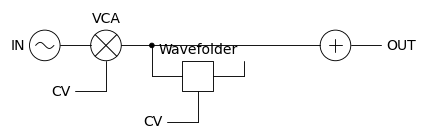

In [3]:
d = schemdraw.Drawing(unit=1, inches_per_unit=0.5, lw=0.9)

d += dsp.Oscillator().right().anchor('N').label('IN', 'left', ofst=.15)
d += dsp.Line()
d += ( mixer := dsp.Mixer().right().anchor('W').label('VCA', 'top', ofst=.15))
d.push()
d += dsp.Line()
d.push()
d += dsp.Dot()
d += dsp.Line().length(5.5)
d += (sum := dsp.Sum().right().anchor('W'))
d += dsp.Line().label('OUT', 'right', ofst=.15)

d.pop()
d += dsp.Line().down()
d += dsp.Line().right()
d += ( folder := dsp.Square().label('Wavefolder', 'top', ofst=.15))
d.push()
d += dsp.Line().right()
d += dsp.Line().up().toy(sum.S)

d.pop()
d += dsp.Line().down().at(folder.S)
d += dsp.Line().left().label('CV', 'left', ofst=.15)

d.pop()
d += dsp.Line().down().at(mixer.S)
d += dsp.Line().left().label('CV', 'left', ofst=.15)

d.draw()


There are three sections in this circuit. First, there is a simple discrete VCA with a long-tailed pair. This circuit was analysed in the ringmod article. The second part is the wavefolder and the third is mixing the signals together. 

The folding itself is done with a diode ladder, where the diodes select different voltages. I think Jürgen has the best explanation of that concept [[1](http://jhaible.com/legacy/jh_wavefolder.html)]. 

In [4]:
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

results = []

for i in np.arange(0, 5, 1) :
    circuit = parser.build_circuit(ground=5)
    circuit.include(spice_library['TL072c'])
    circuit.include(spice_library['TL074c'])
    circuit.include(spice_library['D1N4148'])
    circuit.include(spice_library['BC846B'])

    circuit.V('1', '+15V', circuit.gnd, 'DC 15')
    circuit.V('2', '-15V', circuit.gnd, 'DC -15')
    circuit.V('3', '/input', circuit.gnd, 'DC 5 SIN(0 5V 440)')
    circuit.V('4', '/control', circuit.gnd, 'DC %i' % i)
    circuit.V('5', '/range', circuit.gnd, 'DC 3')

    for c in ( VoltageDivider(R=50@u_kΩ, w=0.5, name='RV4'), 
            VoltageDivider(R=1@u_kΩ, w=0.5, name='RV5') ) :
        circuit.subcircuit(c)

    circuit.R(100, '/shape_a', '/shape_b', 25@u_kΩ)

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    simulator.options('INTERP')
    results.append( simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=20@u_ms) )
    
print(len(results))

5


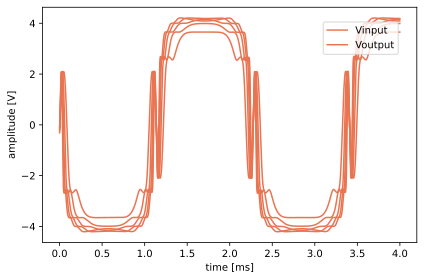

In [5]:
fig_buffer, ax1_buffer = plt.subplots()

ax1_buffer.set_xlabel('time [ms]')
ax1_buffer.set_ylabel('amplitude [V]')
#ax1_buffer.plot(u_ms(analysis['/input'].abscissa), analysis['/input'], color='Blue')
#ax1_buffer.plot(u_ms(analysis['/shape_b'].abscissa), analysis['/shape_b'], color='#E97451')
ax1_buffer.plot(u_ms(results[0]['/out'].abscissa[0:4000]), results[0]['/out'][0:4000], color='#E97451')
ax1_buffer.plot(u_ms(results[0]['/out'].abscissa[0:4000]), results[1]['/out'][0:4000], color='#E97451')
ax1_buffer.plot(u_ms(results[0]['/out'].abscissa[0:4000]), results[2]['/out'][0:4000], color='#E97451')
ax1_buffer.plot(u_ms(results[0]['/out'].abscissa[0:4000]), results[3]['/out'][0:4000], color='#E97451')
ax1_buffer.plot(u_ms(results[0]['/out'].abscissa[0:4000]), results[4]['/out'][0:4000], color='#E97451')
#ax1_buffer.plot(u_ms(analysis['Net-_C7-Pad2_'].abscissa), analysis['Net-_C7-Pad2_'], color='#E97451')


#ax1_buffer.plot(u_ms(analysis['/out'].abscissa), analysis['/out'], color='#E97451')
ax1_buffer.legend(('Vinput', 'Voutput'), loc=(0.75,0.8))

plt.tight_layout()
plt.show()

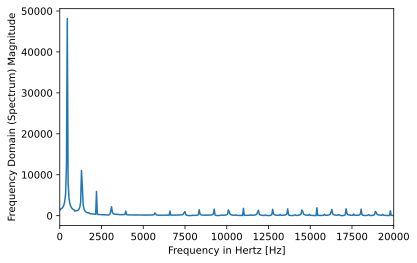

In [6]:
f_s = 1000000  # Sampling rate, or number of measurements per second
N = len(results[0]['/out'])

freq_domain = []
for res in results :
    X = fftpack.fft(res['/out'], res['/out'].size)
    freqs = fftpack.fftfreq(len(res['/out']), 1/f_s)
    peaks, _ = find_peaks(np.abs(X[:N//2]), height=500)
    
    _tmp = [X, freqs, peaks]
    freq_domain.append(_tmp)
    
fig, ax = plt.subplots()

ax.plot(freq_domain[4][1][:N//2], np.abs(freq_domain[4][0][:N//2]))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(0, 20000)
#ax.set_ylim(-5, 110)
plt.show()

In [7]:
volts = 1
for f in freq_domain :
    harmonics = (f[2])
    s = "%iV: " % volts
    for p in f[2] :
        s += "%i " % (round(freqs[p]))
        s += "(%i), " % (round(freqs[p] / 440))    
            
    print( s )
    volts += 1
    


1V: 450 (1), 1300 (3), 2200 (5), 3100 (7), 3950 (9), 4850 (11), 5700 (13), 6600 (15), 7500 (17), 8350 (19), 10999 (25), 
2V: 450 (1), 1300 (3), 1750 (4), 2200 (5), 3100 (7), 3950 (9), 4850 (11), 5700 (13), 6600 (15), 7500 (17), 8350 (19), 9250 (21), 10099 (23), 10999 (25), 11899 (27), 
3V: 450 (1), 950 (2), 1300 (3), 1750 (4), 2200 (5), 3950 (9), 4850 (11), 5700 (13), 6600 (15), 7500 (17), 8350 (19), 9250 (21), 10099 (23), 10999 (25), 11899 (27), 12749 (29), 13649 (31), 14499 (33), 15399 (35), 
4V: 450 (1), 950 (2), 1300 (3), 1750 (4), 2200 (5), 3100 (7), 4850 (11), 5700 (13), 6600 (15), 7500 (17), 8350 (19), 9250 (21), 10099 (23), 10999 (25), 11899 (27), 12749 (29), 13649 (31), 14499 (33), 15399 (35), 16299 (37), 17149 (39), 18049 (41), 
5V: 450 (1), 1300 (3), 1750 (4), 2200 (5), 3100 (7), 3950 (9), 5700 (13), 6600 (15), 7500 (17), 8350 (19), 9250 (21), 10099 (23), 10999 (25), 11899 (27), 12749 (29), 13649 (31), 14499 (33), 15399 (35), 16299 (37), 17149 (39), 18049 (41), 18899 (43), 1

{% include bom.html content="summe-main-bom" %}

For mounting the LED's the long lead has to go to the round pad.

The diodes should be matched in pairs, otherwise, it could be that the folding is not symmetrical (TBH I have not matched them).

{% include callouts.html %}
{% include reports.html%}

# calibration

The discrete VCA in this circuit needs to be calibrated. This is done in two steps. first set the gain of the differential pair and then the control current in the tail. 

1. set the two trimpots to some middle position
2. close the control pot (CCW) and fully open the range pot (CW)
3. connect a sine wave to the input jack
4. connect the scope first channel to your sine wave and the second to the output of the VCA. This is pin1 from U1 or the Resistor R23. 
5. adjust RV5 until both sine waves are the same, maybe also RV4 has to be changed to get a match
6. turn the range pot to silent (CCW) and adjust RV4 until the output is silent too

Now connect your scope to the output. when the wave passes 0V there will be folding. when these foldings look like filled areas there is self-oscillation in the circuit. This can be removed by adding capacitors to the opamps feedback loop. Try using 22-47pF ceramic capacitors for C7 and/or C8.

# usage

A sine or triangle wave can be connected to the module, other waveforms will not work or give strange results. The range controls the amount of folding, this can also be controlled with a CV. For example from an LFO or ADSR. There is a nice effect if the output is connected to a LPG, this results in nice percussive bass sounds. 



# references

- [Jürgen Haible](http://jhaible.com/legacy/jh_wavefolder.html) Wavefolder A+B. The missing images were just still images, there are versions on archive.org with the images. Look for the PDF's on the page.
- [Yusynth](https://www.yusynth.net/Modular/index_en.html) The wavefolder from Yves Usson.
